In [1]:
"""
from OptimizedDataGenerator4 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
noGPU=False
if noGPU:
    tf.config.set_visible_devices([], 'GPU')

print("\nHIIIIIIIIIIIIIIIIII\n")

print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_gpu_available())
"""

from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime
sys.path.append("../ryan")
import OptimizedDataGenerator4 as ODG


sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

2026-01-04 10:31:24.758417: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 10:31:24.799214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-04 10:31:25.048117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-04 10:31:25.048142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-04 10:31:25.050355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


In [2]:
class Model1(SmartPixModel):
    def __init__(self,
            tfRecordFolder: str = "/local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData/",
            nBits: list = None, # just for fractional bits, integer bits
                                ## number of bits is the number of bits for each quantized model and then
                                ## run training should make one model for each bit size
            loadModel: bool = False,
            modelPath: str = None, # Only include if you are loading a model
                        # dropout_rate: float = 0.1,
            initial_lr: float = 1e-3,
            end_lr: float = 1e-4,
            power: int = 2,
            bit_configs = [(16, 0), (8, 0), (6, 0), (4, 0), (3, 0), (2, 0)]  # Test 16, 8, 6, 4, 3, and 2-bit quantization
            ): 
        self.tfRecordFolder = tfRecordFolder
        self.modelName = "Model1" # for other models, e.g., Model 1, Model 2, etc.
        # self.model = None
        self.histories = {}
        self.models = {"Unquantized": None}
        self.bit_configs = bit_configs
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
            self.models[config_name] = None
        # self.quantized_model = None
        self.hyperparameterModel = None
        self.training_generator = None
        self.validation_generator = None
        self.x_feature_description: list = ['z_global','x_size', 'y_size', 'y_local']
        # Learning rate parameters
        self.initial_lr = initial_lr
        self.end_lr = end_lr
        self.power = power
        return
     
    def makeUnquantizedModel(self):
        ## here i will be making a 4-layer neural network 
        ## Model 1: z-global, x size, y size, y local


        ## define the inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

        ## concatenate the inputs into one layer
        inputList = [input1, input2, input3, input4]
        inputs = tf.keras.layers.Concatenate()(inputList)


        ## here i will add the layers 

        stack1 = tf.keras.layers.Dense(17,activation='relu')(inputs)
        stack2 = tf.keras.layers.Dense(20, activation='relu')(stack1)
        stack3 = tf.keras.layers.Dense(9, activation='relu')(stack2)
        stack4 = tf.keras.layers.Dense(16, activation='relu')(stack3)
        stack5 = tf.keras.layers.Dense(18, activation='relu')(stack4)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(stack5)

        self.models["Unquantized"] = tf.keras.Model(inputs=inputList, outputs=output)


    def makeUnquatizedModelHyperParameterTuning(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            row1nodes      = hp.Int("1",   1, 30, step=1)
            row2nodes      = hp.Int("2",   1, 30, step=1)
            row3nodes      = hp.Int("3",   1, 30, step=1)
            row4nodes      = hp.Int("4",   1, 30, step=1)
            row5nodes      = hp.Int("5",   1, 30, step=1)



            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(row1nodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(row2nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row3nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row4nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row5nodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_1_30"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


        
     


    def makeQuantizedModel(self):
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
        
        
            print(f"Building {config_name} model...")
            self.makeQuantizedModel_withBits(total_bits=total_bits,int_bits=int_bits)

    def makeQuantizedModel_withBits(self, total_bits = 8,int_bits =0):
        """
        Build & compile your QKeras model with the given number of integer bits.
        """
        tf.keras.backend.clear_session()
        # inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")
        x = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

        ## I want to try this with 1 int bit and 7 fractional
        ## I want to try this with 0 int bit and 7 fractional
        
        # layer 1
        x = QDense(
            17,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu1"
        )(x)

        # layer 2 (example—you can tweak per‐layer bits)
        x = QDense(
            20,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu2"
        )(x)

        # layer 3
        x = QDense(
            9,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu3"
        )(x)

        # layer 4
        x = QDense(
            16,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu4"
        )(x)

        # layer 5
        x = QDense(
            8,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu5"
        )(x)

        # output
        x = QDense(
            1,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        out = QActivation("smooth_sigmoid")(x)
        config_name = f"quantized_{total_bits}w{int_bits}i"
        self.models[config_name] = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=out)

    """
    @abstractmethod
    def runHyperparameterTuning(self):
        raise NotImplementedError("Subclasses should implement this method.")
    """
    

   

   

In [3]:
m1 = Model1()                 # your subclass

m1.loadTfRecords()            # <-- IMPORTANT: load training/validation generators

m1.makeUnquatizedModelHyperParameterTuning()

Trial 120 Complete [20h 45m 00s]
val_binary_accuracy: 0.8760629892349243

Best val_binary_accuracy So Far: 0.8799141943454742
Total elapsed time: 4d 20h 13m 29s


     trial  row1  row2  row3  row4  row5  params  val_accuracy
0        1    19    16    15    26    12    1423      0.879767
1        2    24     7    16     6     2     542      0.879397
2        3    25    20     6    12    16    1080      0.879712
3        4     3    24     2    27     9     504      0.872374
4        5    22    12     3     8    10     558      0.879524
..     ...   ...   ...   ...   ...   ...     ...           ...
114    115     2     2    21     3    13     211      0.854181
115    116     8    13    12    12    13     664      0.879531
116    117    27     4    11    29    25    1426      0.879325
117    118    26    26    16    24    28    2401      0.879590
118    119    10     1    15    22     9     660      0.876063

[119 rows x 8 columns]


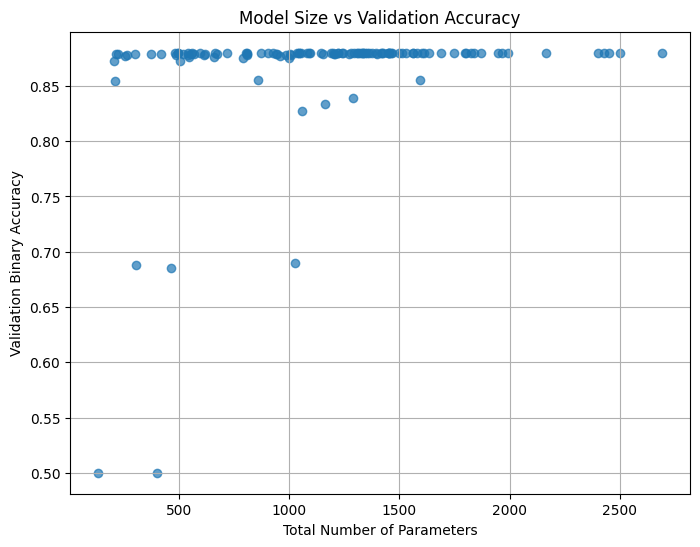

In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1, r2, r3, r4, r5):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r2, activation='relu')(x)
    x = tf.keras.layers.Dense(r3, activation='relu')(x)
    x = tf.keras.layers.Dense(r4, activation='relu')(x)
    x = tf.keras.layers.Dense(r5, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]
    r2 = hp_values["2"]
    r3 = hp_values["3"]
    r4 = hp_values["4"]
    r5 = hp_values["5"]

    val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1, r2, r3, r4, r5)

    results.append({
        "trial": i,
        "row1": r1,
        "row2": r2,
        "row3": r3,
        "row4": r4,
        "row5": r5,
        "params": total_params,
        "val_accuracy": val_acc
    })

df = pd.DataFrame(results)
print(df)

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Model Size vs Validation Accuracy")
plt.grid(True)

plt.show()


   trial  row1  row2  row3  row4  row5  params  val_loss
0      1    19    16    15    26    12    1423  0.279865
1      2    24     7    16     6     2     542  0.282255
2      3    25    20     6    12    16    1080  0.280295
3      4     3    24     2    27     9     504  0.298916
4      5    22    12     3     8    10     558  0.280987


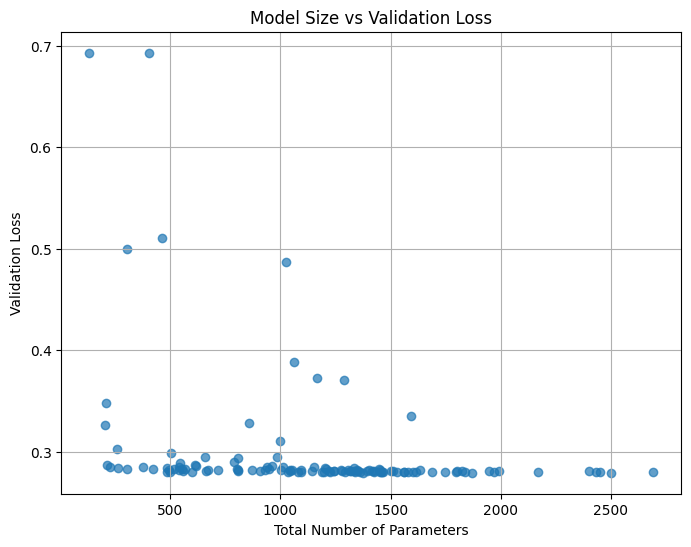

In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1, r2, r3, r4, r5):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r2, activation='relu')(x)
    x = tf.keras.layers.Dense(r3, activation='relu')(x)
    x = tf.keras.layers.Dense(r4, activation='relu')(x)
    x = tf.keras.layers.Dense(r5, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]
    r2 = hp_values["2"]
    r3 = hp_values["3"]
    r4 = hp_values["4"]
    r5 = hp_values["5"]

    val_acc = data["metrics"]["metrics"]["val_loss"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1, r2, r3, r4, r5)

    results.append({
        "trial": i,
        "row1": r1,
        "row2": r2,
        "row3": r3,
        "row4": r4,
        "row5": r5,
        "params": total_params,
        "val_loss": val_acc
    })

df = pd.DataFrame(results)
print(df.head())

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_loss"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Loss")
plt.title("Model Size vs Validation Loss")
plt.grid(True)

plt.show()
